# Installing Packagages

In [2]:
!pip install qiskit --quiet

In [3]:
!pip install pylatexenc --quiet

In [4]:
!pip install qiskit-ibm-runtime --quiet

In [5]:
!pip install qiskit-algorithms --quiet

# Importing Packages

In [44]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos, pi
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator 
import scipy as sc
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
from qiskit.synthesis import SuzukiTrotter
from qiskit.synthesis import SuzukiTrotter
from matplotlib import cm

# IBM API Token

In [45]:
IBM_API = '775d892deb7ca683746f77d5d3e054d71d735c7a87a8111da3e3395ef933c1c9f2f14d7ce90208334fd8ee792466cbbc4398d386ecfa0d923a75114832a16678'

# Defining Parameters of Hamiltonian

In [46]:
params = {
    'L': 3,
    'J': 1,
    'alpha': 1,
}

# Hamiltonian Definition

In [47]:
def get_hamiltonian(params, **kwargs):
    '''
    Returns a general XY Hamiltonian.
    '''
    ## Extract parameters
    L, alpha, J = params['L'], params['alpha'], params['J']
    
    ### Define the XX and YY tuples with corrected list comprehension
    ## List of Hamiltonian terms as 3-tuples containing
    ## (1) the Pauli string,
    ## (2) the qubit indices corresponding to the Pauli string,
    ## (3) the coefficient.
    XX_tuples = [("XX", [i, j], -J / np.power(np.abs(i - j), alpha)) for i in range(L - 1) for j in range(i + 1, L)]
    YY_tuples = [("YY", [i, j], -J / np.power(np.abs(i - j), alpha)) for i in range(L - 1) for j in range(i + 1, L)]
    
    # Combine the tuples to create the Hamiltonian
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples], num_qubits=L)
    return hamiltonian.simplify()

# params = {'L': 3, 'alpha': 1.5, 'J': 1.0}
# hamiltonian = get_hamiltonian(params)

# n-Qubit GHZ Initial State

In [48]:
def get_qc_for_n_qubit_GHZ_state(params, **kwargs):
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        params - only requires 'L' parameter to construct Q.circuit and entangled state.
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
        Entangled n-qubit GHZ state
    """
    n = params['L']
    initial_state = '0' * n
    sv1 = Statevector.from_label(initial_state)
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    new_sv1 = sv1.evolve(qc)
    return qc, new_sv1
 
# GHZ_qc, new_sv1 = get_qc_for_n_qubit_GHZ_state(params)
# display(GHZ_qc.draw('mpl'))
# display(new_sv1.draw('latex'))

# Construction of Observables
### - Correlation Operators $Z_i Z_j$ and it's expectation value
### - Expectation Value of $<Z_i><Z_j>$

In [49]:
def observables_construction(params, **kwargs):
    '''
    Returns the list of observables
    '''
    L = params['L']
    Z_op = SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
    )
    correlation_op = SparsePauliOp.from_sparse_list(
        [("ZZ", [i, j], 1.0) for i in range(0, L - 1) for j in range(i+1, L)], num_qubits=L
    )
    return Z_op, correlation_op
# Z_op, correlation_op = observables_construction(params)
# print(*Z_op)
# print(*correlation_op)

# Time Evolution of the state

In [50]:
params['T'] = 40.0
params['L'] = 5
params['time_step'] = 60
## Assigning Hamiltonian and Observables
H = get_hamiltonian(params)
Z_op, correlation_op = observables_construction(params)
GHZ_qc, initial_state = get_qc_for_n_qubit_GHZ_state(params)

## Defining Time Evolution Problem
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=params['T'],
    aux_operators=[Z_op, correlation_op],
)

## Performing Trotterization
trotter = TrotterQRTE(num_timesteps=params['time_step'], estimator=Estimator())
result = trotter.evolve(problem)

## Extracting results of the observables
observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

/tmp/ipykernel_203/1738167284.py:18: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(num_timesteps=params['time_step'], estimator=Estimator())


(61, 2)

# Plotting of Expectation values of Observable

Text(0.5, 0.98, 'Observable evolution')

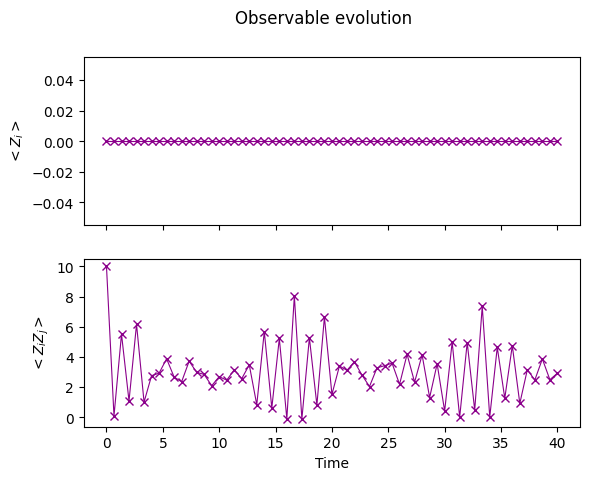

In [51]:
fig, axes = plt.subplots(2, sharex=True)
times = np.linspace(0, params['T'], params['time_step'] + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, np.round(observables[:, 1].astype(float), decimals = 3), label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
# axes[2].plot(
#     times, observables[:, 2], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
# )
axes[0].set_ylabel(f"$<Z_i>$")
axes[1].set_ylabel(f"$<Z_iZ_j>$")
# axes[2].set_ylabel("Mean spin correlation")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

In [154]:
np.round(observables[:, 0].astype(float), decimals = 3)

array([ 0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
       -0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,
        0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.])

# Execution on Real Hardware

## Importing Packages for Execution on Real Hardware

In [52]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

In [53]:
params['T'] = 40.0
params['L'] = 5
params['time_step'] = 60
## Assigning Hamiltonian and Observables
H = get_hamiltonian(params)
Z_op, correlation_op = observables_construction(params)
GHZ_qc, initial_state = get_qc_for_n_qubit_GHZ_state(params)

In [55]:
## If you did not previously save your credentials, use the following line instead:
service = QiskitRuntimeService(channel="ibm_quantum", token=IBM_API)
# service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=params['L'])
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
 
isa_circuit = pm.run(GHZ_qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in correlation_op]

In [56]:
options = EstimatorOptions()
options.resilience_level = 1
# options.dynamical_decoupling.enable = True
# options.dynamical_decoupling.sequence_type = "XY4"
 
## Create an Estimator object
estimator = Estimator(backend, options=options)

In [57]:
## Submit the circuit to Estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

cv8pgs38gpc0008gfcn0


In [59]:
result = job.result()[0]
result

PubResult(data=DataBin(evs=np.ndarray(<shape=(10,), dtype=float64>), stds=np.ndarray(<shape=(10,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(10,), dtype=float64>), shape=(10,)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})

In [64]:
values = result.data.evs # Expectation value at each Z operator.
# values = [v / values[0] for v in values]
values

array([0.7843389 , 0.71577017, 0.82444169, 0.81047382, 0.66030534,
       0.72772277, 0.7362514 , 0.78661088, 0.76698514, 0.98463983])

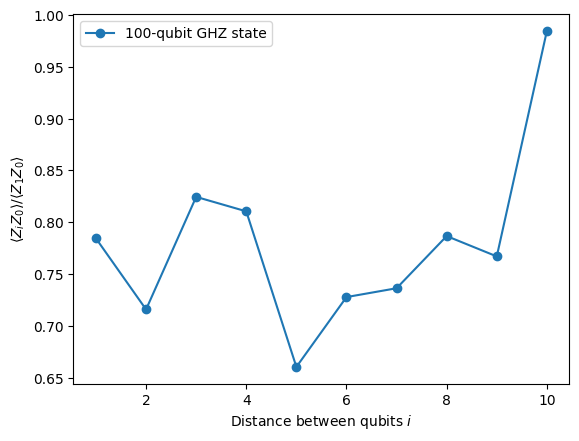

In [67]:
## data
data = list(range(1, len(correlation_op)+1)) # Distance between the Z operators
result = job.result()[0]
values = result.data.evs # Expectation value at each Z operator.
# values = [v / values[0] for v in values] # Normalize the expectation values to evaluate how they decay with distance.
 
# plotting graph
plt.plot(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $')
plt.legend()
plt.show()